# Imports

In [7]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from tqdm import tqdm_notebook as tqdm
import warnings
import logging
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from unidecode import unidecode as decod
from gensim.utils import simple_preprocess
import re
from gensim import corpora, models
import gensim

warnings.filterwarnings("ignore",category=DeprecationWarning)

# LDA Model of skills

## Preprocess downloaded data

In [ ]:
df_final=pd.read_csv("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/linkedin/linkedin_data/linkedin_usrs.csv")
df_skills=[]
skills=[]

marker="####"
for it,row in tqdm(df_final.iterrows()):
    pre_all_skills=row.Skills
    if len(pre_all_skills)==0 or pre_all_skills=='"':
        continue
    usr_skills=[]
    inter=re.split(',|: ',pre_all_skills)
    control=re.split(',|: ',pre_all_skills)[:]
    boola=0
    for indx in range(len(inter)-1):
        if not(inter[indx].isdigit()) and not(inter[indx+1].isdigit()):
            start=indx
            nex=indx+1
            while not(inter[nex].isdigit()) and nex<len(inter)-1:
                nex+=1
            inter[indx]=" ".join(inter[indx:nex])
            for ind in range(indx+1,nex):
                inter[ind]=marker
            boola=1
    pre_pre_final=[x.replace('"','') for x in inter if marker not in x]
    if pre_pre_final[0]==' ':
        del pre_pre_final[0]
    if pre_pre_final[-1]==' ':
        del pre_pre_final[-1]
    for indx in range(len(pre_pre_final)-1): 
        if not(pre_pre_final[indx].isdigit()) and not(pre_pre_final[indx+1].isdigit()):
            pre_pre_final[(indx+1):(indx+1)]=['0']
    pre_final=[]
    for new_indx in range(0,len(pre_pre_final),2):
        pre_final.append((decod(pre_pre_final[new_indx].lower()),
                          int(pre_pre_final[new_indx+1])))
    df=pd.DataFrame(pre_final,columns=["Skill","Upvotes"])
    df_skills.append(df)

skills=[[skill for skill in df.Skill] for df in df_skills ]
upvotes=[[upv for upv in df.Upvotes] for df in df_skills ]
skill2int={skill:it for it,skill in enumerate(set([y for x in skills for y in x]))}

## LDA Model declaration

In [ ]:
mat=np.zeros((len(skills),len(skill2int)))
it=0
for usr_skills,usr_upvotes in zip(skills,upvotes):
    for skill,upvote in zip(usr_skills,usr_upvotes):
        mat[it,skill2int[skill]]=upvote
    it+=1

dictionary = corpora.Dictionary(skills)

corpus = [[(sk[0],upv+1)for sk,upv in zip(dictionary.doc2bow(skill),upvote)]
          for skill,upvote in zip(skills,upvotes)]
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)

## LDAmallet

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/linkedin/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20,workers=20,id2word=dictionary)
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=skills, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
from tqdm  import tqdm
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=skills, 
                                                        start=2, limit=100, step=3)
# Show graph
limit=30; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Prepare pyLDAvis

In [ ]:
new_dat={}
skill_count=Counter([sk for skill in skills for sk in skill])
new_dat["doc_lengths"]=[len(skill) for skill in skills]
new_dat['vocab']=list(skill2int.keys())
new_dat['term_frequency']=[skill_count[k] for k in skill2int.keys()]

In [ ]:
num_topics=10
test_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)
mat_topic_dists=np.zeros((len(corpus),num_topics))
for i in range(len(corpus)):
    for ent,val in test_model[corpus[i]]:
        mat_topic_dists[i,ent]=val
    mat_topic_dists[i,:]=mat_topic_dists[i,:]/np.sum(mat_topic_dists[i,:])
new_dat['doc_topic_dists']=mat_topic_dists

In [ ]:
mat_term_dists=np.zeros((num_topics,len(list(skill2int.keys()))))
for i in range(num_topics):
    for sk,val in test_model.show_topic(i,1000):
        mat_term_dists[i,skill2int[sk]]=val
    mat_term_dists[i,:]=mat_term_dists[i,:]/np.sum(mat_term_dists[i,:])
new_dat['topic_term_dists']=mat_term_dists

In [ ]:
import warnings
warnings.filterwarnings('ignore')
prepared_data = pyLDAvis.prepare(new_dat['topic_term_dists'], new_dat['doc_topic_dists'], 
                                 np.array(new_dat['doc_lengths']) * 1.0, new_dat['vocab'], new_dat['term_frequency'] , mds='tsne')

In [11]:
pyLDAvis.display(prepared_data)

# First Approach: Labeled professions + Tweets

## Textual Features

In [ ]:
import pickle
import unidecode,re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from collections import Counter
from tqdm import tqdm 

#N-Gram vectorizer
french_stopwords = list(set(stopwords.words('french')))
eng_stopwords = list(set(stopwords.words('english')))
linkedin_tweets=pd.read_csv("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/linkedin/linkedin_data/all_linkedin_users.csv",
                            sep=';',header=0,)
usr_text=(linkedin_tweets.dropna(how="any").drop(["tweet_id","tweet_date"],axis=1).groupby(
    'user_id',squeeze=True,)['tweet_text'].apply(lambda x: "%s" % ' '.join(x))).to_frame()
usr_text.reset_index(inplace=True)
nbt=(linkedin_tweets.dropna(how="any").drop(["tweet_id","tweet_date"],axis=1).groupby(
    'user_id',squeeze=True,)['tweet_text'].apply(lambda x: len(x))).to_frame().values
usr_text["nb_tweets"]=[y[0] for y in nbt]


d100=pickle.load(open("/home/jlevyabi/seacabo/data_files/spec_corrected_clusters_only_pos_entries_100.p","rb"))
def get_cluster_info(dic_clus,df_tweets):
    nb_clusters=len(list(dic_clus.keys()))
    word2cluster_only_pos={word:cluster_nb for cluster_nb,cluster_words in dic_clus.items() for word in cluster_words}
    clust_freq_only_pos=[]
    for tweet in tqdm(df_tweets.tweet_text):
        clust_freq_only_pos.append((Counter([word2cluster_only_pos[word]
                                             for word in tweet.split() if word in word2cluster_only_pos])))
    cfd_only_pos=[{k:(v+0.0)/(sum(dic_count.values()))for k,v in dic_count.items()}
                  for dic_count in clust_freq_only_pos]
    df_tweets["cfd_%d"%nb_clusters]=[np.array(list({clus:(dic_count[clus] if clus in dic_count else 0)
                                    for clus in range(len(dic_clus))}.values())) for dic_count in cfd_only_pos]
    return (df_tweets)

usr_text=get_cluster_info(d100,usr_text);

#Tweet Information: N-grams
n_grams_tweet_vect=TfidfVectorizer(stop_words=french_stopwords+eng_stopwords,
                                 max_features=1000,ngram_range=(1,2),
                                lowercase=True)
mat_n_grams_tweet=n_grams_tweet_vect.fit_transform(list(usr_text.tweet_text.values)).todense()
#Tweet Information: Topics
mat_topics_tweet=np.vstack([np.hstack(sample.as_matrix()).reshape((1,100))
                            for it,sample in (usr_text[["cfd_100",]].iterrows())])
# All non-SES info
data_matrix=np.hstack([mat_n_grams_tweet,22])
# Final Synthesis
usr_text["fts"]=[row for row in data_matrix.tolist()]

## SES features

### Skills Prediction

In [ ]:
import operator

# Print list of top skills associated to cluster
topic_of_interest=2
(sorted({new_dat['vocab'][x]:new_dat['topic_term_dists'][topic_of_interest,x] 
        for x in np.where(new_dat['topic_term_dists'][topic_of_interest,:]>0)[0]}.items(),
       reverse=True, key=operator.itemgetter(1))[:5])


In [ ]:
# Preparing skills 
df_show=df_final[np.array([bool(1-int(len(x)==0 or x=='"'))
                  for x in df_final.Skills.values])][["Title",
                                                      "Organization Title 1",
                                                      "Profile url","id"]].rename(index=str,
                                                                                  columns= {"id":"linkedin_id"},
                                                                                  inplace=False,)

for i in range(num_topics):
    df_show["top_%d"%(i+1)]=new_dat['doc_topic_dists'][:,i]
    
data_annots=pd.read_csv(sep="\t",header=-1,names=["sth","twitter_id","twitter_name","linkedin_url"],
filepath_or_buffer="/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/twitter_linked_accounts_no_rep_france.csv")

from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

from tqdm import tqdm_notebook as tqdmn
matrix = np.array([[similar(x,y) for y in data_annots.linkedin_url]for x in tqdmn(df_show.linkedin_id)])

df_show["assoc_linkedin_url"]=[data_annots["linkedin_url"].iloc[x] for x in np.argmax(matrix,axis=1)]
df_show["twitter_id"]=[data_annots["twitter_id"].iloc[x] for x in np.argmax(matrix,axis=1)]
ses_text_skills=pd.merge(usr_text,df_show,left_on="user_id",right_on="twitter_id")

# Features
mat_topics_tweet=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text_skills.iloc[0]["fts"])))
                            for it,sample in (ses_text_skills[["fts",]].iterrows())])

# Target: Maximal Topic
mat_info_linkedin=np.vstack([ses_text_skills[["top_%d"%i for i in range(1,11) ]].values[j] 
                    for j in range(ses_text_skills.shape[0])])
class_info_linkedin_max=np.argmax(mat_info_linkedin,axis=1)

In [61]:
ses_text_skills.head()

,user_id,tweet_text,nb_tweets,cfd_100,fts,Title,Organization Title 1,Profile url,linkedin_id,top_1,...,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,assoc_linkedin_url,twitter_id
0,462113,jeff bezos s reign as the world s richest pers...,1700,"[0.0139955537591, 0.00197049312854, 0.02561641...","[0.033692945815386226, 0.040178939777736115, 0...",Consultant en transformation digitale,Consultant en transformation digitale,https://www.linkedin.com/in/jeanchristophe/,jeanchristophe,0.443644,...,0.0,0.168292,0.000000,0.0,0.124504,0.263559,0.000000,0.000000,https://fr.linkedin.com/in/jeanchristophe,462113
1,617143,le directeur interministeriel a la transformat...,1870,"[0.00329055610398, 0.000987166831194, 0.011893...","[0.009005924993411428, 0.0521186120691614, 0.0...",Chargé de mission / Chef de projet - Innovatio...,Consultant Sénior,https://www.linkedin.com/in/loichay/,loichay,0.153456,...,0.0,0.000000,0.153376,0.0,0.083713,0.000000,0.089834,0.252441,https://fr.linkedin.com/in/loichay,617143
2,617143,le directeur interministeriel a la transformat...,1870,"[0.00329055610398, 0.000987166831194, 0.011893...","[0.009005924993411428, 0.0521186120691614, 0.0...",Chargé de mission / Chef de projet - Innovatio...,Consultant Sénior,https://www.linkedin.com/in/loichay/,loichay,0.153414,...,0.0,0.000000,0.153378,0.0,0.083679,0.000000,0.089943,0.252399,https://fr.linkedin.com/in/loichay,617143
3,803709,education a la ibm watson apprendre plus tot q...,1584,"[0.0072861920688, 0.00017916865743, 0.03338509...","[0.030006923854674884, 0.014884669734470526, 0...",Impact Philanthropy and Moonshot Ventures for ...,President - Cofounder -,https://www.linkedin.com/in/edouardbrauer/,edouardbrauer,0.810955,...,0.0,0.000000,0.000000,0.0,0.000000,0.189045,0.000000,0.000000,https://fr.linkedin.com/in/edouardbrauer,803709
4,818241,l idee meme du zerohumain amene a la question ...,3048,"[0.0047234307023, 0.0011187072716, 0.013838823...","[0.0031013247485474254, 0.015554779330627209, ...",Digital Transformation - Digital Strategy,Digital Transformation - Digital Strategy,https://www.linkedin.com/in/pierremawas/,pierremawas,0.229717,...,0.0,0.103090,0.195320,0.0,0.103694,0.368178,0.000000,0.000000,http://fr.linkedin.com/in/pierremawas,818241


#### Target: Skill associated to argmax

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM" ,
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    ]

X = StandardScaler().fit_transform(mat_topics_tweet)
y = class_info_linkedin_max
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
clf_arrs=[]
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    clf_arrs.append(clf)
    score = clf.score(X_test, y_test)
    print ("%d-Classification accuracy for %s:  %f"%(len(set(y)),name,score))

In [16]:
from operator import itemgetter
from collections import defaultdict, Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer, StandardScaler, scale
from sklearn import model_selection, metrics
from sklearn.metrics import roc_auc_score, brier_score_loss, make_scorer, f1_score, fbeta_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from scipy.stats import uniform
from xgboost import XGBClassifier

clf = RandomForestClassifier(n_estimators=1000, n_jobs=1)
param_distributions = {'criterion': ['gini', 'gini', 'entropy'],
                       'max_depth': range(2,50),
                       'min_samples_split': uniform(loc=0, scale=0.2),
                       'min_samples_leaf': uniform(loc=0, scale=0.2),
                       'bootstrap': [True, True, False]}


n_splits = 5
n_repeats = 5
n_iter = 500
n_jobs = -1
verbose = 1

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
model = RandomizedSearchCV(clf, param_distributions, n_iter=n_iter, scoring=scorer, n_jobs=n_jobs, cv=cv, verbose=verbose)

model.fit(X_train, y_train)
print("Best model parameters: ", model.best_params_)
print("Best model roc auc score: ", model.best_score_)

#### Checkpoint

In [20]:
import pickle
pickle.dump( {"X":X,"mat_topics_tweet":mat_topics_tweet,"mat_info_linkedin":mat_info_linkedin,"ses_text_skills":ses_text_skills},
            open( "/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/linkedin/linkedin_data/lkd_data.p", "wb" ) )

In [11]:
import pickle
dic_full=pickle.load(open("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/linkedin/linkedin_data/lkd_data.p","rb"))
X=dic_full["X"]
mat_topics_tweet=dic_full["mat_topics_tweet"]
mat_info_linkedin=dic_full["mat_info_linkedin"]
ses_text_skills=dic_full["ses_text_skills"]

In [12]:
mat_info_linkedin=np.vstack([ses_text_skills[["top_%d"%i for i in range(1,11) ]].values[j] 
                    for j in range(ses_text_skills.shape[0])])
class_info_linkedin_max=np.argmax(mat_info_linkedin,axis=1)
y = class_info_linkedin_max
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#### Finetuning

In [17]:
from operator import itemgetter
from collections import defaultdict, Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer, StandardScaler, scale
from sklearn import model_selection, metrics
from sklearn.metrics import roc_auc_score, brier_score_loss, make_scorer, f1_score, fbeta_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from scipy.stats import uniform
from sklearn.metrics import accuracy_score


clf = RandomForestClassifier(n_estimators=1000, n_jobs=1)
param_distributions = {'criterion': ['gini', 'gini', 'entropy'],
                       'max_depth': range(2,50),
                       'min_samples_split': uniform(loc=0, scale=0.2),
                       'min_samples_leaf': uniform(loc=0, scale=0.2),
                       'bootstrap': [True, True, False]}


n_splits = 5
n_repeats = 5
n_iter = 100
n_jobs = -1
verbose = 1

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
scorer = make_scorer(accuracy_score, greater_is_better=True, needs_threshold=True)
model = RandomizedSearchCV(clf, param_distributions, n_iter=n_iter, n_jobs=n_jobs, cv=cv, verbose=verbose)

model.fit(X_train, y_train)
print("Best model parameters: ", model.best_params_)
print("Best model roc auc score: ", model.best_score_)


Fitting 25 folds for each of 100 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1122 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 2322 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 37.2min finished


Best model parameters:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 49, 'min_samples_leaf': 0.0080856497844938643, 'min_samples_split': 0.033086799914125491}
Best model roc auc score:  0.378541953232


In [35]:
from sklearn.metrics import accuracy_score
rf_model = RandomForestClassifier(n_estimators=1000, bootstrap=False, criterion='gini',
                                  max_depth=49, min_samples_leaf=0.00808564,
                                  min_samples_split=0.0330868, n_jobs=25)

n_splits = 20
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1)

y_pred_proba, y_test, ids_pred,y_pred = [], [], [], []
for valtrain_index, valtest_index in cv.split(X_train, y_train):
    X_valtrain, X_valtest = X_train[valtrain_index], X_train[valtest_index]
    y_valtrain, y_valtest = y_train[valtrain_index], y_train[valtest_index]
    #ids_valtrain, ids_valtest = ids_train[valtrain_index], ids_train[valtest_index]
    rf_model.fit(X_valtrain, y_valtrain)
    y_valpred_proba = rf_model.predict_proba(X_valtest)[:,1]
    y_pred_proba.append(y_valpred_proba)
    y_pred.append(rf_model.predict(X_valtest))
    y_test.append(y_valtest)
    #ids_pred.append(ids_valtest)

y_pred = np.hstack(y_pred)    
y_pred_proba = np.hstack(y_pred_proba)
y_test = np.hstack(y_test)

#ids_pred = np.hstack(ids_pred)
print("RF model ROC AUC score on %d folds cross-validation: "%n_splits, accuracy_score(y_test, y_pred))
print("RF model Brier score on %d folds cross-validation: "%n_splits, brier_score_loss(y_test, y_pred_proba))

RF model ROC AUC score on 20 folds cross-validation:  0.378610729023
RF model Brier score on 20 folds cross-validation:  0.130537604272


### Income Prediction

In [53]:
import pandas as pd 
label_data=pd.read_csv(error_bad_lines=False,
                       filepath_or_buffer="/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/linkedin/linkedin_data/full_linkedin_sofar.csv")

In [ ]:
f_locs="/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/icdm18/issues/dic_all_users_inf_no_fake_insee.p"


In [188]:
ses_text_insee[yes_estimated_sal][["estimated_sal",
                                   "user_id"]].to_csv("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/icdm18/issues/linkedin_salaries.csv")#estimated_sal

In [109]:
import re,numpy as np
regex_sals = re.compile('[^0-9]')
treat_sal=lambda x: regex_sals.sub("",x) if type(x) is str else ""
salaries_per_usr=[]
last_salaries_per_usr=[]

for it,row in  label_data[["Salary 1","Salary 2","Salary 3","Salary 4"]].iterrows():
    sal1,sal2,sal3,sal4=map(treat_sal,row.values.tolist())
    all_sals=[]
    last_sal=np.nan
    if type(sal1) is str and len(sal1)>0:
        all_sals.append(int(sal1))
        last_sal=int(sal1)
    if type(sal2) is str and len(sal2)>0:all_sals.append(int(sal2))
    if type(sal3) is str and len(sal3)>0:all_sals.append(int(sal3))
    if type(sal4) is str and len(sal4)>0:all_sals.append(int(sal4))
    if len(all_sals)>0:
        salaries_per_usr.append(np.mean(all_sals))
        last_salaries_per_usr.append(np.max(all_sals))
    else:
        salaries_per_usr.append(np.nan)
        last_salaries_per_usr.append(np.nan)
    

salaries_per_usr=np.array(salaries_per_usr)
last_salaries_per_usr=np.array(last_salaries_per_usr)

label_data["estimated_sal"]=salaries_per_usr
label_data["last_estimated_sal"]=last_salaries_per_usr

In [181]:
ses_text_insee.head()

,user_id,tweet_text,nb_tweets,cfd_100,fts,Title_x,Organization Title 1,Profile url_x,linkedin_id,top_1,...,Organization Title 3_y,Organization 3_y,Organization Title 4_y,Organization 4_y,Salary 1,Salary 2,Salary 3,Salary 4,estimated_sal,last_estimated_sal
0,462113,jeff bezos s reign as the world s richest pers...,1700,"[0.0139955537591, 0.00197049312854, 0.02561641...","[0.033692945815386226, 0.040178939777736115, 0...",Consultant en transformation digitale,Consultant en transformation digitale,https://www.linkedin.com/in/jeanchristophe/,jeanchristophe,0.443644,...,Commercial Aftermarket/Retail Development Dire...,Volvo Trucks France,"Director, Europe area, parts and service sales...",Automobiles Peugeot,NaN,NaN,57 754 €,NaN,57754.0,57754.0
1,617143,le directeur interministeriel a la transformat...,1870,"[0.00329055610398, 0.000987166831194, 0.011893...","[0.009005924993411428, 0.0521186120691614, 0.0...",Chargé de mission / Chef de projet - Innovatio...,Consultant Sénior,https://www.linkedin.com/in/loichay/,loichay,0.153456,...,Chargé de mission Innovation Numérique Territo...,"La Fonderie, agence numérique d'Île-de-France",Chargé de mission Internet Public & Citoyen,ARTESI - Agence Régionale des Technologies et ...,NaN,NaN,NaN,50 431 €,50431.0,50431.0
2,617143,le directeur interministeriel a la transformat...,1870,"[0.00329055610398, 0.000987166831194, 0.011893...","[0.009005924993411428, 0.0521186120691614, 0.0...",Chargé de mission / Chef de projet - Innovatio...,Consultant Sénior,https://www.linkedin.com/in/loichay/,loichay,0.153456,...,Chargé de mission Innovation Numérique Territo...,"La Fonderie, agence numérique d'Île-de-France",Chargé de mission Internet Public & Citoyen,ARTESI - Agence Régionale des Technologies et ...,NaN,NaN,NaN,50 431 €,50431.0,50431.0
3,617143,le directeur interministeriel a la transformat...,1870,"[0.00329055610398, 0.000987166831194, 0.011893...","[0.009005924993411428, 0.0521186120691614, 0.0...",Chargé de mission / Chef de projet - Innovatio...,Consultant Sénior,https://www.linkedin.com/in/loichay/,loichay,0.153414,...,Chargé de mission Innovation Numérique Territo...,"La Fonderie, agence numérique d'Île-de-France",Chargé de mission Internet Public & Citoyen,ARTESI - Agence Régionale des Technologies et ...,NaN,NaN,NaN,50 431 €,50431.0,50431.0
4,617143,le directeur interministeriel a la transformat...,1870,"[0.00329055610398, 0.000987166831194, 0.011893...","[0.009005924993411428, 0.0521186120691614, 0.0...",Chargé de mission / Chef de projet - Innovatio...,Consultant Sénior,https://www.linkedin.com/in/loichay/,loichay,0.153414,...,Chargé de mission Innovation Numérique Territo...,"La Fonderie, agence numérique d'Île-de-France",Chargé de mission Internet Public & Citoyen,ARTESI - Agence Régionale des Technologies et ...,NaN,NaN,NaN,50 431 €,50431.0,50431.0


In [115]:
from sklearn.preprocessing import StandardScaler

ses_text_insee=pd.merge(ses_text_skills,label_data,left_on="user_id",right_on="twitter_id")
mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text_insee.iloc[0]["fts"])))
                            for it,sample in (ses_text_insee[["fts",]].iterrows())])
mat_info_skills=np.hstack((np.vstack(([ses_text_skills[["top_%d"%i for i in range(1,11) ]].values[j] 
                       for j in range(ses_text_insee.shape[0])])),mat_info))
X = StandardScaler().fit_transform(mat_info)
X_skills=np.hstack((np.vstack(([ses_text_skills[["top_%d"%i for i in range(1,11) ]].values[j] 
                       for j in range(ses_text_insee.shape[0])])),X))


yes_estimated_sal=~np.isnan(ses_text_insee.estimated_sal)
medin=np.median(ses_text_insee.estimated_sal[yes_estimated_sal])
ses_iris_class=np.array(ses_text_insee.estimated_sal[yes_estimated_sal]>medin).astype(np.int)# 2 class


yes_estimated_last_sal=~np.isnan(ses_text_insee.last_estimated_sal)
medin_last=np.median(ses_text_insee.last_estimated_sal[yes_estimated_last_sal])
ses_iris_class_last=np.array(ses_text_insee[yes_estimated_last_sal].last_estimated_sal>medin_last).astype(np.int)# 2 class

In [183]:
(ses_iris_class_last).shape

(3147,)

### Basic Prediction

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


def train_generator(X_train, X_test, y_train, y_test):
    nms = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Random Forest", "Neural Net", "AdaBoost"]
    clfs = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1),
        AdaBoostClassifier()]

    classif_results=[]
    for name, clf in zip(nms, clfs):
        clf.fit(X_train, y_train)
        score = roc_auc_score(y_test,clf.predict(X_test))
        classif_results.append(clf)
        print ("2-Classification RAUC for %s:  %f"%(name,score))
    return classif_results

print("Med Sal:Only language")
X_train, X_test, y_train, y_test = train_test_split(X[yes_estimated_sal], ses_iris_class,
                                                    test_size=.33, random_state=42)

clfs_med_sal_lang=train_generator(X_train, X_test, y_train, y_test)


print("Last Sal:Only language")
X_train, X_test, y_train, y_test = train_test_split(X[yes_estimated_last_sal], ses_iris_class_last,
                                                    test_size=.33, random_state=42)
clfs_last_sal_lang=train_generator(X_train, X_test, y_train, y_test)

    
print("Med Sal: Language + Skills")
X_train, X_test, y_train, y_test = train_test_split(X_skills[yes_estimated_sal], ses_iris_class,
                                                    test_size=.33, random_state=42)
clfs_med_sal_lang_skill=train_generator(X_train, X_test, y_train, y_test)

print("Last Sal: Language + Skills")
X_train, X_test, y_train, y_test = train_test_split(X_skills[yes_estimated_last_sal], ses_iris_class_last,
                                                    test_size=.33, random_state=42)

clfs_last_sal_lang_skills=train_generator(X_train, X_test, y_train, y_test)

Med Sal:Only language
2-Classification RAUC for Nearest Neighbors:  0.628549
2-Classification RAUC for Linear SVM:  0.647597
2-Classification RAUC for RBF SVM:  0.572381
2-Classification RAUC for Random Forest:  0.607236
2-Classification RAUC for Neural Net:  0.689263
2-Classification RAUC for AdaBoost:  0.668936
Last Sal:Only language
2-Classification RAUC for Nearest Neighbors:  0.602416
2-Classification RAUC for Linear SVM:  0.590928
2-Classification RAUC for RBF SVM:  0.576509
2-Classification RAUC for Random Forest:  0.513197
2-Classification RAUC for Neural Net:  0.632309
2-Classification RAUC for AdaBoost:  0.617581
Med Sal: Language + Skills
2-Classification RAUC for Nearest Neighbors:  0.628529
2-Classification RAUC for Linear SVM:  0.649522
2-Classification RAUC for RBF SVM:  0.572381
2-Classification RAUC for Random Forest:  0.613882
2-Classification RAUC for Neural Net:  0.675827
2-Classification RAUC for AdaBoost:  0.668936
Last Sal: Language + Skills
2-Classification RAUC

### Random Forest : FineTuning

In [148]:
from operator import itemgetter
from collections import defaultdict, Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer, StandardScaler, scale
from sklearn import model_selection, metrics
from sklearn.metrics import roc_auc_score, brier_score_loss, make_scorer, f1_score, fbeta_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from scipy.stats import uniform

clf = RandomForestClassifier(n_estimators=1000, n_jobs=1)
param_distributions = {'criterion': ['gini', 'gini', 'entropy'],
                       'max_depth': range(2,50),
                       'min_samples_split': uniform(loc=0, scale=0.2),
                       'min_samples_leaf': uniform(loc=0, scale=0.2),
                       'bootstrap': [True, True, False]}


n_splits = 5
n_repeats = 5
n_iter = 100
n_jobs = -1
verbose = 1

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
model = RandomizedSearchCV(clf, param_distributions, n_iter=n_iter, scoring=scorer, n_jobs=n_jobs, cv=cv, verbose=verbose)

model.fit(X_train, y_train)
print("Best model parameters: ", model.best_params_)
print("Best model roc auc score: ", model.best_score_)


Fitting 25 folds for each of 100 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1122 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 2322 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 17.8min finished


Best model parameters:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 37, 'min_samples_leaf': 0.00052846356844606925, 'min_samples_split': 0.016366667878739017}
Best model roc auc score:  0.778115696162


In [151]:
fitted_clf = RandomForestClassifier(n_estimators=1000, n_jobs=1,
                                   bootstrap=False, criterion='entropy',max_depth= 37,
                                    min_samples_leaf= 0.00052846356844606925,
                                    min_samples_split=0.016366667878739017)
fitted_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=37, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None,
            min_samples_leaf=0.0005284635684460693,
            min_samples_split=0.016366667878739017,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [195]:
print(classification_report(y_test,fitted_clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.71      0.78      0.74       514
          1       0.76      0.69      0.72       525

avg / total       0.73      0.73      0.73      1039



### XGBoost: Fine Tuning

In [ ]:
clf_xgb_best = XGBClassifier(silent=True,
                             objective='binary:logistic', nthread=1,
                             colsample_bylevel=0.711042696916055,
                             colsample_bytree=0.647155668828931,
                             gamma=0.07378142164921973,
                             learning_rate=0.03635030937272931,
                             max_depth=47,
                             min_child_weight=1,
                             n_estimators=660,
                             reg_alpha=0.029747313785977683,
                             reg_lambda=0.913531,
                             subsample=0.8419288031101905,
                             scale_pos_weight=1, base_score=0.5,
                            n_jobs=40)

clf_xgb_best.fit(X_train,y_train)

In [ ]:
print(classification_report(y_test,clf_xgb_best.predict(X_test)))

In [196]:
import pickle
dic_linkedin_data={"xtrain":X_train,"xtest":X_test,"ytrain":y_train,"ytest":y_test}
pickle.dump(dic_linkedin_data,open("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/icdm18/issues/dic_linkedin_data.p","wb"))

In [ ]:
import pickle
dic_linkedin_data=pickle.load(open("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/icdm18/issues/dic_linkedin_data.p","rb"))
X_train=dic_linkedin_data["xtrain"]
y_train=dic_linkedin_data["ytrain"]
X_test=dic_linkedin_data["xtest"]
y_test=dic_linkedin_data["ytest"]

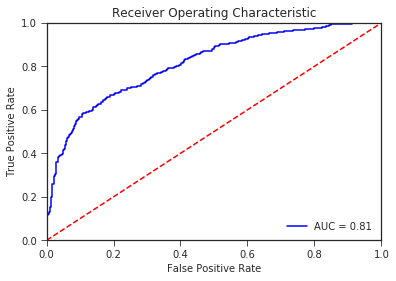

In [153]:
probs = clf_xgb_best.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
probs = clf_xgb_best.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


In [189]:
dic_linkedin_xgb={
    "fpr":fpr,
    "tpr":tpr,
    "roc_auc":roc_auc,
}
import pickle
pickle.dump(dic_linkedin_xgb,open("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/icdm18/issues/dic_linkedin_xgb.p","wb"))

### XGBoost Tuning

In [166]:
import pickle
d_test_brunch={"Xtrain":X_train,"Xtest":X_test,"Ytrain":y_train,"Ytest":y_test}
pickle.dump(d_test_brunch,
            open( "/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/linkedin/linkedin_data/xgb_data.p","wb"))

In [ ]:
import pickle
d_test_brunch=pickle.load(open("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/linkedin/linkedin_data/xgb_data.p","rb"))

X_train=d_test_brunch["Xtrain"]
X_test=d_test_brunch["Xtest"]
y_train=d_test_brunch["Ytrain"]
y_test=d_test_brunch["Ytest"]

#### XGBoost Wide FineTune

In [ ]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(silent=True, objective='binary:logistic', nthread=1,
                    scale_pos_weight=1, base_score=0.5)

param_distributions = {"max_depth": range(3,50),
                       "learning_rate": uniform(loc=0, scale=0.1),
                       "n_estimators": range(10, 1500),
                       "min_child_weight": range(1, 200),
                       "gamma": uniform(loc=0, scale=0.1),
                       "subsample": uniform(loc=0.7, scale=0.3),
                       "colsample_bytree": uniform(loc=0.5, scale=0.5),
                       "colsample_bylevel": uniform(loc=0.1, scale=0.9),
                       "reg_alpha": uniform(loc=0, scale=0.2),
                       "reg_lambda": uniform(loc=0.8, scale=0.2)}

n_splits = 5
n_repeats = 5
n_iter = 500
n_jobs = -1
verbose = 1

cv_xgb = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
scorer_xgb = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
model_xgb = RandomizedSearchCV(clf_xgb, param_distributions, n_iter=n_iter, scoring=scorer_xgb, n_jobs=n_jobs, cv=cv_xgb, verbose=verbose)

model_xgb.fit(X_train, y_train)
print("Best model parameters: ", model_xgb.best_params_)
print("Best model roc auc score: ", model_xgb.best_score_)



In [176]:
from sklearn.metrics import classification_report
clf_xgb_best= XGBClassifier(silent=True,
                            objective='binary:logistic',
                            nthread=1,
                            colsample_bylevel= 0.11638275228153268, 
                            colsample_bytree= 0.5339149690805822,
                            gamma= 0.0036203619173286517,
                            max_depth=45,
                            learning_rate= 0.0071063978043349185,
                            min_child_weight= 3,
                            n_estimators=834,
                            reg_alpha=0.10967082619706092, 
                            reg_lambda=0.8440183906183637,
                            subsample= 0.7292758412112841,
                            scale_pos_weight=1, 
                            base_score=0.5)
clf_xgb_best.fit(X_train, y_train)

print(classification_report(y_test,clf_xgb_best.predict(X_test)))

             precision    recall  f1-score   support

          0       0.72      0.76      0.74       514
          1       0.75      0.71      0.73       525

avg / total       0.73      0.73      0.73      1039



#### XGBoost Narrow FineTune

In [ ]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(silent=True, objective='binary:logistic', nthread=1,
                    scale_pos_weight=1, base_score=0.5)

param_distributions = {"max_depth": range(35,50),
                       "colsample_bylevel": uniform(loc=0.12, scale=0.02),
                       "colsample_bytree":uniform(loc=0.54, scale=0.05),
                       "gamma": uniform(loc=.003, scale=0.001),
                       "learning_rate":uniform(loc=0.007, scale=0.001),
                       "min_child_weight":range(2, 10)
                       "n_estimators":range(800, 1000),
                       "reg_alpha":uniform(loc=0.1, scale=0.03),
                       "reg_lambda":uniform(loc=0.84, scale=0.01),
                       "subsample": uniform(loc=0.7, scale=0.03),
                      }

n_splits = 5
n_repeats = 5
n_iter = 500
n_jobs = -1
verbose = 1

cv_xgb = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
scorer_xgb = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
model_xgb = RandomizedSearchCV(clf_xgb, param_distributions, n_iter=n_iter, scoring=scorer_xgb, n_jobs=n_jobs, cv=cv_xgb, verbose=verbose)

model_xgb.fit(X_train, y_train)
print("Best model parameters: ", model_xgb.best_params_)
print("Best model roc auc score: ", model_xgb.best_score_)

In [ ]:
from sklearn.metrics import classification_report
clf_xgb_best= XGBClassifier(silent=True,
                            objective='binary:logistic',
                            nthread=1,
                            colsample_bylevel= 0.8556967312487654, 
                            colsample_bytree= 0.9522114445860427,
                            gamma= 0.038330151455541875,
                            max_depth=9,
                            learning_rate= 0.02318653583710998,
                            min_child_weight= 3,
                            n_estimators=855,
                            reg_alpha=0.1697681292416028, 
                            reg_lambda=0.8982229632071087,
                            subsample= 0.9038370292861182,
                            scale_pos_weight=1, 
                            base_score=0.5)
clf_xgb_best.fit(X_train, y_train)

print(classification_report(y_test,clf_xgb_best.predict(X_test)))

### Finetuning with Dirichlet

In [ ]:
%load_ext rp

In [51]:
%%R -i ses_text_skills
df %>% 
  gather("Category", "X") %>%
  ggplot(aes(x = Category, y = X, fill = Category)) +
    geom_violin() +
    stat_summary(fun.y=mean, color='black', geom='point', size = 3) +
    labs(title = "Violin plot",
         subtitle = "Means indicated as black dots",
         captions = "Numbers generated in Numpy") +
    theme_bw()


ERROR:root:Line magic function `%R` not found.


In [52]:
%%R
lake1 <- DirichReg(AL ~ depth, ArcticLake)

ERROR:root:Cell magic `%%R` not found.


In [405]:
%%R X=c(1,4,5,7); sd(X); mean(X)
%%R  Y = c(2,4,3,9)


UsageError: Cell magic `%%R` not found.


### Annotated SES Prediction

### SES Predictions Professions Titles + Tweets

In [1]:
import pandas as pd 
df_final=pd.read_csv(error_bad_lines=False,
                       filepath_or_buffer="/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/"+
                     "linkedin/linkedin_data/annotated_with_twitter.csv")

In [106]:
import numpy as np
from unidecode import unidecode
regex = re.compile('[^a-zA-Z0-9-,/ ]')
pretreat_title=lambda x: regex.sub("",unidecode(x.lower().replace("@"," at "))) if type(x) is str else ""
df_final["treated_tile"]=list(map(pretreat_title,df_final.Title))

remove_from_job=[
    "benevole","benevolat","eleve","apprenticeship","apprentie","apprenti",
    "apprentice","apprentie","stage","stagiaire","trainee",
    "intern","internship","etudiant","student","degree","master"
    "etudiante","ambassadeur","ambassadrice","ambassador",
    "alumni","fondateur","fondatrice","founder","entrepreneur",
    "ceo","chief executive officer","cofounder","co fondateur",
    "cofondateur","co-founder","owner","co-fondateur","co-fondatrice","apprentissage","alternance",
    "alternant","rotation","mba","membre","graduate","master",
    "volunteer","militant","volontaire","volontariat",
    "volunteering","volounteer","chairman","volonteer","volontaires","--","opportunite","nouv","a la recherche"]


to_do_properly=df_final[["id","Title","treated_tile"]].drop_duplicates("id").sort_values("treated_tile")
to_do_properly=to_do_properly[[np.sum([int(y.isalpha()) for y in x])>4 for x in to_do_properly.Title]]

to_do_properly=to_do_properly[[np.all([not(y in x) for y in remove_from_job]) for x in to_do_properly.treated_tile]]
to_do_properly=to_do_properly[[not(type(x) is float )for x in to_do_properly.treated_tile]].drop("treated_tile",axis=1)
to_do_properly["UKSOC"]=["" for i in range(to_do_properly.shape[0])]
to_do_properly["INSEE"]=["" for i in range(to_do_properly.shape[0])]

In [108]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.line_width', 200)
to_do_properly.to_csv("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/finalannot.csv")

In [112]:
to_do_properly=pd.read_csv("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/finalannot.csv",sep=";")

In [171]:
from collections import Counter
d=Counter(to_do_properly[[type(u) is str for u in to_do_properly.UKSOC]].UKSOC)
x=to_do_properly[[type(u) is str and d[u]>100 for u in to_do_properly.UKSOC]]

In [172]:
categ=pd.merge(x,ses_text_insee,left_on="id",right_on="id")
full=categ[["id","fts","UKSOC"]].drop_duplicates("id")

In [173]:
mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(full.iloc[0]["fts"])))
                            for it,sample in (full[["fts",]].iterrows())])
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(mat_info)
ses_iris_class_try=np.array(full.UKSOC)# 2 class

In [174]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Random Forest", "Neural Net", "AdaBoost"]
classif_results=[]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier()]

X_train, X_test, y_train, y_test = train_test_split(X, ses_iris_class_try,
                                                    test_size=.2, random_state=42)
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    classif_results.append(clf)
    print ("2-Classification accuracy for %s:  %f"%(name,score))

2-Classification accuracy for Nearest Neighbors:  0.597315
2-Classification accuracy for Linear SVM:  0.637584
2-Classification accuracy for RBF SVM:  0.577181
2-Classification accuracy for Random Forest:  0.570470


/home/jlevyabi/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2-Classification accuracy for Neural Net:  0.657718
2-Classification accuracy for AdaBoost:  0.630872


In [175]:
print(classification_report(y_test,classif_results[-2].predict(X_test)))

             precision    recall  f1-score   support

        113       0.41      0.31      0.35        29
        213       0.61      0.65      0.63        34
        247       0.74      0.78      0.76        86

avg / total       0.64      0.66      0.65       149



### Other Stuff

In [54]:
import pandas as pd 
df_final=pd.read_csv(error_bad_lines=False,
                       filepath_or_buffer="/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/"+
                     "linkedin/linkedin_data/annotated_with_twitter.csv")


In [17]:
# Trabajos sin acentos y con letras o numeros 
import numpy as np
import re
from unidecode import unidecode
regex = re.compile('[^a-zA-Z ]')
pretreat_title=lambda x: regex.sub("",unidecode(x.lower())) if type(x) is str else ""
df_final["treated_tile"]=list(map(pretreat_title,df_final.Title))

remove_from_job=[
    "benevole","benevolat","eleve","apprenticeship","apprentie","apprenti",
    "apprentice","apprentie","stage","stagiaire","trainee",
    "intern","internship","etudiant","student","degree","master"
    "etudiante","ambassadeur","ambassadrice","ambassador",
    "alumni","fondateur","fondatrice","founder","entrepreneur",
    "ceo","chief executive officer","cofounder","co fondateur",
    "cofondateur","co-founder","owner","co-fondateur","co-fondatrice","apprentissage","alternance",
    "alternant","rotation","mba","membre","graduate","master",
    "volunteer","militant","volontaire","volontariat",
    "volunteering","volounteer","chairman","volonteer","volontaires","--",]

df_final_no_student_ceo=df_final[[np.all([not(y in x) for y in remove_from_job]) for x in df_final.treated_tile]]
df_final_no_student_ceo=df_final_no_student_ceo[[not(type(x) is float )for x in df_final_no_student_ceo.Title]]
df_final_no_student_ceo["INSEE"]=["" for i in range(df_final_no_student_ceo.shape[0])]



### Automatic assignments

def fill_jobs(df_data,pat,insee_descr,data_annot=None):
    tr_title=list(df_data["treated_tile"])
    if data_annot==None:
        data_annot={tr_title[it]:[] for it in range(df_data.shape[0])}
    for it,treated_work in enumerate(df_data["treated_tile"]):
        if re.search(pat, treated_work):
            data_annot[tr_title[it]].append(insee_descr)
    return data_annot

#### UKSOC

###### 1. MANAGERS, DIRECTORS AND SENIOR OFFICIALS

area1="(production|engineering|operation|general|immobilier|achat|account|graphic|fashion|fitness|estate|personnel|recruitement|treasury|tresor|compte|construction|investment|logistics|logistique|talent acquisition|recrutement|recruitment|investissment|insurance|assurance|financ|purchasing)"
poste1="(direct(or|eur|ice)|manager|propriet(or|aire)|chef de |head of|vp|president|vicepresident|vice president|cpo|cfo|cdo|cto|coo|chief)"
otherar1="(it|sales|vente|data|business develop|financ|computer services|general|conseil|informatique|technique|technical|telecommunications|parlament|parlement|marketing|publicite|advertising|human ressources|ressources humaines|rh|hr|bank|banque|retail|vente|wholesale|hotel|sports|transport|travel|ingenierie|voyage|accomodation|care|waste|social media|public relations|relations publiques|pr |rp  )"
otherpos1="(direct(or|eur|rice|ion)|deputy|depute|delegue|collabo|partner)"
full1=r"^([a-z\s\b]+|)(((%s([a-z\s ]+)%s)|(%s([a-z\s ]+)%s))|(%s([a-z\s ]+)%s|%s([a-z\s ]+)%s))([a-z\s]+|)$"%(
    area1,poste1,poste1,area1,otherar1,otherpos1,otherpos1,otherar1)
pat1=re.compile(full1)

annots=fill_jobs(df_final_no_student_ceo,pat1,"1")



###### 2. Professional Occupations

spec2="( cours |cabinet|ater|td |profess(or|eur)|comptable|fellow|geograph|infirm|pharma|histo(ry|ire)|attorney|histori(e|a)n|ingenieur|engineer| ecole | school |college |lycee |maître |aggrege |capes |enseignant|fellow|lecturer|tutor|tuteur|economist|journalis|reporter|archivist|conservat(eur|rice|or)|editor|psycho|therap|medecin|environment|energ|scient|avocat |devops|juge|juriste| legal |law|accountant|statistic|devops|fullstack|python|java|ux | ui | app |iosandroid|programm(er|eur)|cnrs| inra | inria |bibliothec|doctorant|chercheur|chercheuse|research)"
area2="(it |digital|quality|qa |multimedia|software|creative|risk|policy|campaign|publicite|public relations|brand|relations publiques|pr |rp |communication|seo)"
poste2="(clerk|tester|charge|consult(ant|ing)|manager|analyst|officer|advis(e|o)r|engineer|formation|chef(|fe) de)"

full2=re.compile(r"^([a-z\s\b]+|)((%s)|(%s([a-z\s ]+)%s)|(%s([a-z\s ]+)%s))([a-z\s]+)$"%(spec2,area2,poste2,poste2,area2))
pat2=re.compile(full2)

annots=fill_jobs(df_final_no_student_ceo,pat2,"2",annots)



###### 3. ASSOCIATE PROFESSIONAL AND TECHNICAL OCCUPATIONS

spec3="(artist| art |ecrivain|coach|architecte si|musique|cadreur|edit(eur|ice)|format(eur|rice)|business develop|community manager|sig|axa|trader|fund|tax|insurance|impot|audit|credit|assurance|insurance|events|fund|export|import|mortgage|cartogr|illustrat|graphiste|fashion|designer|blog|singer|chant|dan(c|s)e|armee|coreo|choreo|musici(a|e)n|pianist|photograph|projection|dj |theatr|camera|studio|pilot|navy|traduct|translator|monteur|producer|realisat(eur|rice)|interpret|culture|compositor|author|poete|fichiste|auteur|ecrivain|football)"
area3="(network|invest|fusion|dta| systems| it |sales|vente|achat|business develop|television|TV|database| architect|quality|lab|dental|graphic|recruitment|recrutement|talent acquisition|hr |rh |human ressources | ressources humaines |formation| training |format(eur|rice)|events|evenements|securite|safety|conferenc|marketing|publicite|seo)"
poste3="(admin|assistant|charge|technici(a|e)n|support|controller|consultant|officer|organisation|coordin|producer|analyst)"
full3=re.compile(r"^([a-z\s\b]+|)((%s)|(%s([a-z\s ]+)%s)|(%s([a-z\s ]+)%s))([a-z\s]+)$"%(spec3,area3,poste3,poste3,area3))
pat3=re.compile(full3)
annots=fill_jobs(df_final_no_student_ceo,pat3,"3",annots)


###### 4 ADMINISTRATIVE AND SECRETARIAL OCCUPATIONS

spec4="(secreta|reception|pueri|f(a|e)rm|jardin|culteur)"
area4="(administrative)"
poste4="assistant"
full4=re.compile(r"^([a-z\s\b]+|)((%s)|(%s([a-z\s ]+)%s)|(%s([a-z\s ]+)%s))([a-z\s]+)$"%(spec4,area4,poste4,poste4,area4))
pat4=re.compile(full4)
annots=fill_jobs(df_final_no_student_ceo,pat4,"4",annots)




In [31]:
from collections import Counter

def Most_Common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

df_final_no_student_ceo["cat"]=[Most_Common(annots[val]) if len(annots[val])>0 else "" for val in  df_final_no_student_ceo.treated_tile]
label_data=df_final_no_student_ceo[df_final_no_student_ceo.cat!=""]

In [180]:
import re,numpy as np
regex_sals = re.compile('[^0-9]')
treat_sal=lambda x: regex_sals.sub("",x) if type(x) is str else ""
salaries_per_usr=[]
for it,row in  label_data[["Salary 1","Salary 2","Salary 3","Salary 4"]].iterrows():
    sal1,sal2,sal3,sal4=map(treat_sal,row.values.tolist())
    all_sals=[]
    if type(sal1) is str and len(sal1)>0:all_sals.append(int(sal1))
    if type(sal2) is str and len(sal2)>0:all_sals.append(int(sal2))
    if type(sal3) is str and len(sal3)>0:all_sals.append(int(sal3))
    if type(sal4) is str and len(sal4)>0:all_sals.append(int(sal4))
    if len(all_sals)>0:
        salaries_per_usr.append(np.max(all_sals))
    else:
        salaries_per_usr.append(np.nan)

salaries_per_usr=np.array(salaries_per_usr)
label_data["estimated_sal"]=salaries_per_usr

In [36]:
import pickle
import unidecode,re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
#N-Gram vectorizer
french_stopwords = list(set(stopwords.words('french')))
eng_stopwords = list(set(stopwords.words('english')))

linkedin_tweets=pd.read_csv("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/linkedin/linkedin_data/all_linkedin_users.csv",
                            sep=';',header=0,)
usr_text=(linkedin_tweets.dropna(how="any").drop(["tweet_id","tweet_date"],axis=1).groupby(
    'user_id',squeeze=True,)['tweet_text'].apply(lambda x: "%s" % ' '.join(x))).to_frame()
usr_text.reset_index(inplace=True)
nbt=(linkedin_tweets.dropna(how="any").drop(["tweet_id","tweet_date"],axis=1).groupby(
    'user_id',squeeze=True,)['tweet_text'].apply(lambda x: len(x))).to_frame().values

usr_text["nb_tweets"]=[y[0] for y in nbt]

In [37]:
from collections import Counter
from tqdm import tqdm 

d100=pickle.load(open("/home/jlevyabi/seacabo/data_files/spec_corrected_clusters_only_pos_entries_100.p","rb"))
def get_cluster_info(dic_clus,df_tweets):
    nb_clusters=len(list(dic_clus.keys()))
    word2cluster_only_pos={word:cluster_nb for cluster_nb,cluster_words in dic_clus.items() for word in cluster_words}
    clust_freq_only_pos=[]
    for tweet in tqdm(df_tweets.tweet_text):
        clust_freq_only_pos.append((Counter([word2cluster_only_pos[word]
                                             for word in tweet.split() if word in word2cluster_only_pos])))
    cfd_only_pos=[{k:(v+0.0)/(sum(dic_count.values()))for k,v in dic_count.items()}
                  for dic_count in clust_freq_only_pos]
    df_tweets["cfd_%d"%nb_clusters]=[np.array(list({clus:(dic_count[clus] if clus in dic_count else 0)
                                    for clus in range(len(dic_clus))}.values())) for dic_count in cfd_only_pos]
    return (df_tweets)

usr_text=get_cluster_info(d100,usr_text);

100%|██████████| 3568/3568 [00:37<00:00, 94.95it/s]


In [38]:
#Tweet Information: N-grams
n_grams_tweet_vect=CountVectorizer(stop_words=french_stopwords+eng_stopwords,
                                 max_features=1000,ngram_range=(1,2),
                                lowercase=True)

mat_n_grams_tweet=n_grams_tweet_vect.fit_transform(list(usr_text.tweet_text.values)).todense()

#Tweet Information: Topics
mat_topics_tweet=np.vstack([np.hstack(sample.as_matrix()).reshape((1,100))
                            for it,sample in (usr_text[["cfd_100",]].iterrows())])

# All non-SES info
data_matrix=np.hstack([mat_n_grams_tweet,mat_topics_tweet])

# Final Synthesis
usr_text["fts"]=[row for row in data_matrix.tolist()]
ses_text_insee=pd.merge(usr_text,label_data,left_on="user_id",right_on="twitter_id")

In [39]:
ses_text_insee.head()

,user_id,tweet_text,nb_tweets,cfd_100,fts,Unnamed: 0,twitter_id,twitter_name,Unnamed: 0.1,Address,...,Summary,Title,Twitter,Website 1,Website 2,Website 3,id,treated_tile,INSEE,cat
0,617143,le directeur interministeriel a la transformat...,1870,"[0.003290556103981573, 0.0009871668311944718, ...","[4.0, 30.0, 4.0, 16.0, 16.0, 3.0, 15.0, 9.0, 3...",986,617143,LoicHay,1047,NaN,...,De formation universitaire en droit et science...,Chargé de mission / Chef de projet - Innovatio...,LoicHay,http://www.doyoubuzz.com/loic-hay,NaN,NaN,loichay,charge de mission chef de projet innovation ...,,1
1,818241,l idee meme du zerohumain amene a la question ...,3048,"[0.004723430702299565, 0.0011187072715972653, ...","[2.0, 13.0, 1.0, 3.0, 13.0, 0.0, 3.0, 5.0, 2.0...",1344,818241,Pem,1435,NaN,...,Senior executive in internet and digital indus...,Digital Transformation - Digital Strategy,Pem,NaN,NaN,NaN,pierremawas,digital transformation digital strategy,,2
2,4386291,merci vincent je trouve cela inquietant les ma...,552,"[0.017706721677840813, 0.00034381983840467596,...","[1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",253,4386291,MATCOUL,256,NaN,...,19 years of experience in IP/ IT law Legal and...,"Head of legal, Microsoft France",MATCOUL,http://www.syntec-numerique.fr/,NaN,NaN,mathieucoulaud,head of legal microsoft france,,2
3,4469831,etat des lieux 2018 l usage d internet des res...,1677,"[0.005457545373778398, 0.0005711384693489022, ...","[7.0, 18.0, 2.0, 10.0, 3.0, 2.0, 6.0, 5.0, 5.0...",287,4469831,echomienne,290,NaN,...,📧 echomienne@gmail.com Ingénieure d'études à l...,"Ingénieure en innovation numérique, Formatrice...",echomienne,NaN,NaN,NaN,chomienne,ingenieure en innovation numerique formatrice ...,,2
4,5710102,peut etre un service qui posterait tes annonce...,634,"[0.007589556769884639, 0.0004553734061930783, ...","[4.0, 3.0, 2.0, 2.0, 1.0, 0.0, 2.0, 4.0, 1.0, ...",831,5710102,easyalexis,890,NaN,...,NaN,Chief Digital Officer/ Marketing Technologist,EasyAlexis,http://www.strategies.fr/emploi-formation/mana...,http://fr.mashable.com,NaN,alexisthobellem,chief digital officer marketing technologist,,2


In [40]:
ses_text_insee=pd.merge(usr_text[usr_text.nb_tweets>100],label_data,left_on="user_id",right_on="twitter_id")
mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text_insee.iloc[0]["fts"])))
                            for it,sample in (ses_text_insee[["fts",]].iterrows())])
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(mat_info)
#medin=np.median(ses_text_insee.estimated_sal[~np.isnan(ses_text_insee.estimated_sal)])
ses_iris_class_try=ses_text_insee.cat#np.array(ses_text_insee.estimated_sal>medin).astype(np.int)# 2 class

In [41]:
ses_text_insee.shape

(1145, 157)

In [190]:
usr_text.head()

,user_id,tweet_text,cfd_100,fts,nb_tweets
0,462113,jeff bezos s reign as the world s richest person was short lived ai and the retail store of the future kaspersky lance une version gratuite de son antivirus free mobile attention aux numeros speciaux qui commencent par 08 si vous etes a l etranger this is the best 3 minute startup pitch you ll ever see paris canal swimming pool opens with a splash le tweet mal adresse qui se transforme en une campagne creative l intelligence artificielle pourrait faire grimper le pib mondial d ici 2030 c est quoi live nation l organisateur de concerts geants the board directors you need for a digital transformation sapvoice banking and ai why we also need the human touch 5 fintech startups under the radar pourquoi fetons nous le 14 juillet avec un feu d artifice blockchain could make the insurance industry much more transparent paypal s new apple partnership leaves square on the outskirts l elysee choisit un pur produit banque de france pour le gendarme de la bourse trois mois apres son lancement l...,"[0.013995553759094583, 0.0019704931285367826, 0.02561641067097817, 0.042643492320129345, 0.02192805173807599, 0.0015662894098625708, 0.007073565076798707, 0.012429264349232014, 0.007831447049312854, 0.005658852061438965, 0.002475747776879547, 0.027940582053354892, 0.019856507679870655, 0.0022736459175424413, 0.06310630557801132, 0.0005557801131770413, 0.008690379951495554, 0.0004042037186742118, 0.01162085691188359, 0.0003031527890056589, 0.004496766370250606, 0.002879951495553759, 0.003637833468067906, 0.002223120452708165, 0.10595189975747776, 0.002122069523039612, 0.002879951495553759, 0.005608326596604689, 0.008437752627324172, 0.0019704931285367826, 0.01935125303152789, 0.0002526273241713824, 0.00010105092966855295, 0.00717461600646726, 0.00045472918350848826, 0.012934518997574777, 0.013086095392077607, 0.004143088116410671, 0.044967663702506065, 0.004850444624090542, 0.0045978172999191595, 0.0033346806790622474, 0.0013136620856911885, 0.0017683912691996767, 0.0021725949878738...","[11.0, 17.0, 7.0, 4.0, 4.0, 2.0, 5.0, 11.0, 5.0, 2.0, 3.0, 0.0, 6.0, 3.0, 12.0, 3.0, 3.0, 3.0, 5.0, 3.0, 7.0, 10.0, 0.0, 2.0, 2.0, 2.0, 3.0, 5.0, 12.0, 1.0, 3.0, 6.0, 1.0, 2.0, 3.0, 0.0, 1.0, 1.0, 3.0, 4.0, 1.0, 1.0, 2.0, 3.0, 3.0, 19.0, 0.0, 3.0, 2.0, 2.0, 6.0, 5.0, 6.0, 5.0, 2.0, 11.0, 4.0, 1.0, 9.0, 3.0, 22.0, 2.0, 0.0, 1.0, 4.0, 2.0, 4.0, 2.0, 13.0, 0.0, 8.0, 3.0, 10.0, 0.0, 1.0, 0.0, 0.0, 2.0, 14.0, 0.0, 5.0, 0.0, 10.0, 2.0, 7.0, 0.0, 12.0, 1.0, 1.0, 1.0, 3.0, 3.0, 2.0, 1.0, 3.0, 3.0, 13.0, 0.0, 2.0, 2.0, ...]",1700
1,617143,le directeur interministeriel a la transformationpublique cherche a recruter un directeur trice de les outils d animation proposes par et presentes sous la forme de fiches consultables ou telechargeable attention au choc thermique bon voyage amigo pouvez vous poster cette propositi a part la description de l offre et les prix impossible de voir un exemple de au dela des plugins opensource existants desormais 3 outils simples pour comparer 2 images rephotographie befo un petit nouveau tres prometteur par dans la famille des outils de dataviz une bibliot merci antoine des que j aurai termine de faire le tour de certains sujets cles je compte inaugu 5 merci jean louis gamestorming jouer pour innover par est une collection d outils de co innovation games par luke hohman est un livre qui detaille 12 jeux qui permettent de collaborer avec v guide de survie aux reunions par regroupe et presente 40 techniques design your sprint par est un jeu de cartes qui reference des outils organises a ...,"[0.003290556103981573, 0.0009871668311944718, 0.011893009918676256, 0.06247355803130729, 0.03859352230526959, 0.0012222065529074414, 0.006064024820194613, 0.03262351337376017, 0.03483288675786208, 0.004089691157805669, 0.001833309829361162, 0.010999858976166971, 0.03013209232360269, 0.002350397217129695, 0.11972923424058667, 0.0008461429981666902, 0.02472617872420439, 0.0002820476660555634, 0.0026794528275

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# No ejecutar !! Los resultados son los mismos que en la imagen de abajo
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Random Forest", "Neural Net", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier()]

X_train, X_test, y_train, y_test = train_test_split(X, ses_iris_class_try,
                                                    test_size=.2, random_state=42)
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print ("2-Classification accuracy for %s:  %f"%(name,score))

2-Classification accuracy for Nearest Neighbors:  0.427948
2-Classification accuracy for Linear SVM:  0.449782
2-Classification accuracy for RBF SVM:  0.545852
2-Classification accuracy for Random Forest:  0.550218
2-Classification accuracy for Neural Net:  0.506550
2-Classification accuracy for AdaBoost:  0.480349


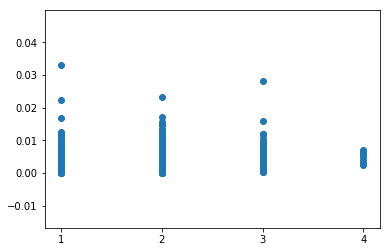

In [52]:
import matplotlib.pyplot as plt
ix=(n_grams_tweet_vect).get_feature_names().index("fait")
plt.scatter(ses_text_insee.cat,mat_info[:,999+23]+1e-6)
plt.show()

In [46]:
clf=RandomForestClassifier(max_depth=5, n_estimators=10, max_features=10)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
print(classification_report(y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

          1       0.46      0.12      0.20        48
          2       0.56      0.95      0.70       125
          3       0.50      0.02      0.04        53
          4       0.00      0.00      0.00         3

avg / total       0.52      0.55      0.43       229



/home/jlevyabi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
classification_report?